# Kmeans
Lập trình Kmeans và các phương pháp tìm K tối ưu

In [1]:
import numpy as np
import pandas as pd
import random as rd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Xây dựng Class Kmean bao gồm thuật toán Kmeans và các phương pháp tìm k tối ưu kèm theo.

In [33]:
class KMean():
    def __init__(self, X, max_iters=50, plot_steps=False, init='kmeans++'):
        self.X=X
        self.n,self.d = X.shape
        self.max_iters=max_iters
        self.plot_steps = plot_steps
        self.initial = init

    # nhom kmean
            # lay k tam theo thuat toan Kmeans++ 
    def kmean_plus_plus(self,k):
        centroids_temp = []
        centroids_temp.append(self.X[np.random.choice(self.n)])
        for _ in range(k-1):
            dist= []
            for i in range(self.n):
                data = self.X[i,:]
                temp_dist=[]
                for centroid in centroids_temp:
                    temp_dist.append(np.sum((data - centroid)**2))
                dist.append(np.min(temp_dist))
            centroids_temp.append(self.X[np.argmax(dist),:])
        centroids_temp = np.array(centroids_temp)
        return centroids_temp
    
        # lay k tam nhau nhien
    def kmean_random_centroids(self,k): 
        return self.X[np.random.choice(self.n,k,replace=False)]
        
        # Tinh khoang cach Euclid tu cac diem den cac tam
    def kmean_euclid_dis(self,k):
        distances=np.zeros((self.n,k))
        for i in range(k):
            for j in range(self.d):
                distances[:,i]+=(self.X[:,j]-self.centroids[i,j])**2
        distances=np.sqrt(distances)
        return distances
    
        # lay nhan cua cac diem gan voi cac tam nhat
    def kmean_assign_labels(self,k):
        distances = self.kmean_euclid_dis(k)
        return np.argmin(distances,axis=1)
    
        # tinh lai vi tri cac tam
    def kmean_update_centroids(self,k):
        return np.array([np.mean(self.X[self.labels == i,:],axis=0) for i in range(k)])
    
        # Kiem tra xem 2 tam co trung nhau khong
    def kmean_check_centroids(self, new_centroids):
        return (set([tuple(i) for i in self.centroids])==set([tuple(i) for i in new_centroids])) # Vu Huu Tiep book
    
        # Tao cac Cluster
    def kmean_create_clusters(self):
        self.clusters = [self.X[self.labels == i,:] for i in range(len(self.centroids))]
        return self.clusters
    
        # Plot kmean
    def kmean_plot(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        defi_color=['b','g','r','c','m','y','k','b','g','r','c','m','k','w','b','g','r']
        for i in range(len(self.centroids)):
            ax.scatter(self.clusters[i][:,0],self.clusters[i][:,1],marker='o',color=defi_color[i],alpha=0.7,s=8**2)
            ax.scatter(self.centroids[i,0],self.centroids[i,1],marker='x',color='k',s=12**2)
        plt.show()


        # Chay thuat toan Kmean
    def fit(self,k,plot_steps=True):
        if self.initial.lower() in ['random','rd']:
            self.centroids=self.kmean_random_centroids(k) # Thiet lap tam ngau nhien k tam nhau nhien ban dau
        elif self.initial == 'kmeans++':
            self.centroids=self.kmean_plus_plus(k)
        for _ in range(self.max_iters):
            
            self.labels=self.kmean_assign_labels(k)
                        
            self.clusters=self.kmean_create_clusters()
            if plot_steps and self.plot_steps:
                self.kmean_plot()
                
            new_centroids = self.kmean_update_centroids(k)
            if self.kmean_check_centroids(new_centroids):
                break
            self.centroids=new_centroids

        
        return self.centroids, self.labels
    
    # Nhom Elbow
        # Ham elbow
    def elbow_method(self,num):
        elbow_values = np.zeros(num+1)
        elbow_values[0]=None
        for i in range(1,num+1):
            Centroids,labels=self.fit(i,plot_steps=False)
            for j in range(i):
                elbow_values[i]+=np.sum((self.X[labels==j,:]-Centroids[j])**2)
        self.elbow_values=elbow_values
        return elbow_values
        
        # Hien thi cac gia tri cua elbow method
    def Print_elbow_method(self):
        try:
            for i in range(1,len(self.elbow_values)):
                print('k={}:{}'.format(i,self.elbow_values[i]))
        except :
            print("No values in elbow method yet!")
        
        # Bieu do hoa cac gia tri cua elbow method
    def Show_elbow_method(self):
        try:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(self.elbow_values,'or-')
            ax.set_title('Elbow method')
            ax.set_xlabel('Number of K')
            ax.set_ylabel('Total Within Sum of Square')
            
            plt.show()
        except:
            print("No values in elbow method yet!")
    # Nhom Silhouette
        # Ham silhoutte
    def silhouette_method(self,num,Test=True):
        self.silh_num = num
        Silhoue_mean=np.zeros(num+1)
        Silhoue_mean[0]=Silhoue_mean[1]=None
        Silh_k=[]
        silh_kmean_values=[]
        if Test == True:
            for k in range(2,num+1):
                X_centroids_s, labels_s=self.fit(k, plot_steps=False)
                silh_kmean_values.append([X_centroids_s, labels_s])
                Xlabels=np.concatenate((self.X,labels_s.reshape(-1,1)),axis=1)
                silh=np.zeros((self.n,2))
                for index in range(self.n):
                    Si=self.X[index]
                    #Tách các cụm.
#                        print(Xlabels,Xlabels[index,self.d])
                    Atemp = Xlabels[Xlabels[:,self.d]==Xlabels[index,self.d]]
                    Btemp = Xlabels[Xlabels[:,self.d]!=Xlabels[index,self.d]]
#                     print('Btemp',index,Btemp[:1])
                    #Chọn một giá trị ngẫu nhiên trong cụm và loại bỏ giá trị đã chọn trong cụm đó.
                    if Si in Atemp:
                        Atemp=np.delete(Atemp,np.where(Atemp==Si),axis=0)
                    if Si in Btemp:
                        Btemp=np.delete(Btemp,np.where(Btemp==Si),axis=0)
        
                    if (Atemp.shape[0]-1)==0: # Nếu số lượng phần tử trong cụm = 1 thì trả về 0 để tránh trường hợp chia cho 0.
                        silh[Si]=0
                        continue
                    # Tổng khoảng cách từ i đến các phần tử j trong cụm
                    SumSa=0
                    for j in range(Atemp.shape[1]-1):
                        SumSa+=(Si[j]-Atemp[:,j])**2

                    SumSa=np.sum(np.sqrt(SumSa))

                    SA = (1/(Atemp.shape[0]-1))*SumSa
                    # Tổng khoảng cách từ i đến các phần tử không thuộc cụm i
                    othercl=np.delete(np.array(range(k)),int(Xlabels[index,self.d]))
#                     print("othercl",index,othercl[:1])
                    TempBtemp =np.zeros(k-1) # Biến lưu các khoảng cách để chọn giá trị thấp nhất.
                    for l in range(k-1):
                        SumSb = 0
                        Temp1=Btemp[Btemp[:,self.d]==othercl[l]] # lấy các phần tử thuộc các cụm khác cụm của i.
#                             print(Temp1)
                        for j in range(Temp1.shape[1]-1):
                            SumSb+=(Si[j]-Temp1[:,j])**2
                        SumSb=np.sum(np.sqrt(SumSb))
                        TempBtemp[l]=(1/Temp1.shape[0])*SumSb
                    SB = np.amin(TempBtemp,axis=0)
                    silh[index]=[(SB-SA)/(np.max([SB,SA])),Xlabels[index,self.d]]
#                     print('silh[{}]:{}'.format(index,silh[index]))
                Silh_k.append(silh)
                Silhoue_mean[k]=np.mean(silh[:,0])
            self.Silhoue_mean=Silhoue_mean
            self.Silh_k_values=Silh_k
            self.Silh_kmean_values= silh_kmean_values
            return Silh_k
        else:
            for k in range(2,num+1):
                X_centroids_s, labels_s=self.fit(k, plot_steps=False)
                Xlabels=np.concatenate((self.X,labels_s.reshape(-1,1)),axis=1)
                silh=np.zeros(k)
                for i in range(k):
                    #Tách các cụm.
                    Atemp = Xlabels[Xlabels[:,self.d]==i]
                    Btemp = Xlabels[Xlabels[:,self.d]!=i]
                    #Chọn một giá trị ngẫu nhiên trong cụm và loại bỏ giá trị đã chọn trong cụm đó.
                    rd_values=rd.randint(0,Atemp.shape[0]-1)
                    Si=Atemp[rd_values]
                    Atemp=np.delete(Atemp,rd_values,axis=0)
                    if (Atemp.shape[0]-1)==0: # Nếu số lượng phần tử trong cụm = 1 thì trả về 0 để tránh trường hợp chia cho 0.
                        silh[i]=0
                        continue
                    # Tổng khoảng cách từ i đến các phần tử j trong cụm
                    SumSa=0
                    for j in range(Atemp.shape[1]-1):
                        SumSa+=(Si[j]-Atemp[:,j])**2

                    SumSa=np.sum(np.sqrt(SumSa))

                    SA = (1/(Atemp.shape[0]-1))*SumSa
                    # Tổng khoảng cách từ i đến các phần tử không thuộc cụm i
                    othercl=np.delete(np.array(range(k)),i)

                    TempBtemp =np.zeros(k-1) # Biến lưu các khoảng cách để chọn giá trị thấp nhất.
                    for l in range(k-1):
                        SumSb = 0
                        Temp1=Btemp[Btemp[:,self.d]==othercl[l]] # lấy các phần tử thuộc các cụm khác cụm của i.
                        for j in range(Temp1.shape[1]-1):
                            SumSb+=(Si[j]-Temp1[:,j])**2
                        SumSb=np.sum(np.sqrt(SumSb))
                        TempBtemp[l]=(1/Temp1.shape[0])*SumSb
                    SB = np.amin(TempBtemp,axis=0)
                    silh[i]=(SB-SA)/(np.max([SB,SA]))
                Silhoue_mean[k]=np.mean(silh)
                self.silhouette_values=Silhoue_mean
            return Silhoue_mean
    
        # Hien thi cac gia tri cua silhoutte method
    def Print_silhoutte_method(self):
        try:
            for i in range(2,len(self.Silhoue_mean)):
                print('k={}:{}'.format(i,self.Silhoue_mean[i]))
        except :
            print("No values in silhoutte method yet!")
    def Show_silhoutte_method(self,s=True):
        try:
            if s is False:
                plt.plot(self.silhouette_values,'or-')
                plt.show()
            if s is True:
                
                for k in range(2,self.silh_num+1):
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.set_size_inches(18, 7)
                    ax1.set_xlim([-0.1, 1])
                    ax1.set_ylim([0, self.n + (k + 1) * 10])
                    clusterer, cluster_labels = self.Silh_kmean_values[k-2] #Km3.fit(k)
                    Texx=self.Silh_k_values[k-2]
                    y_lower = 10
                    for i in range(k):
                        ith_cluster_silhouette_values = Texx[Texx[:,1]==i]
                        ith_cluster_silhouette_values= ith_cluster_silhouette_values[:,0]
                        ith_cluster_silhouette_values.sort()
                        size_cluster_i = ith_cluster_silhouette_values.shape[0]
                        y_upper = y_lower + size_cluster_i
                        color = cm.nipy_spectral(float(i) / k)
                        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)
                            # Label the silhouette plots with their cluster numbers at the middle
                        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                        # Compute the new y_lower for next plot
                        y_lower = y_upper + 10  # 10 for the 0 samples
                    ax1.set_title("The silhouette plot for the various clusters.")
                    ax1.set_xlabel("The silhouette coefficient values")
                    ax1.set_ylabel("Cluster label")

                    # The vertical line for average silhouette score of all the values
                    ax1.axvline(x=self.Silhoue_mean[k], color="red", linestyle="--")

                    ax1.set_yticks([])  # Clear the yaxis labels / ticks
                    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                    # 2nd Plot showing the actual clusters formed
                    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
                    ax2.scatter(self.X[:, 0], self.X[:, 1], marker='o', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')
        except:
            print("No values in silhoutte method yet!")
    # Nhom Gap Statisitc 

#### Làm mô tả cho Chương II.1.a

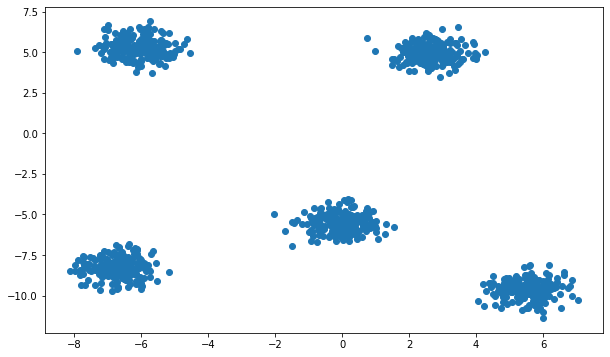

In [3]:
from sklearn.datasets import make_blobs
# %matplotlib qt
features, true_labels = make_blobs(n_samples=1000,n_features=2,centers=5,cluster_std=0.6,random_state=10)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.scatter(features[:,0],features[:,1])
plt.show()

In [4]:
Km1=KMean(features,init='rd',plot_steps=True)

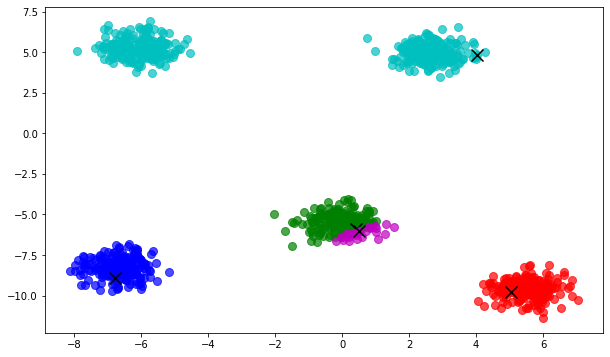

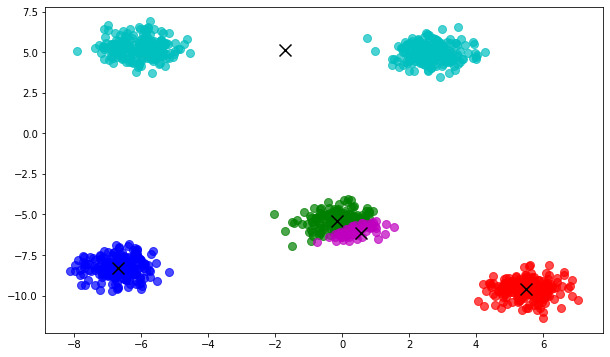

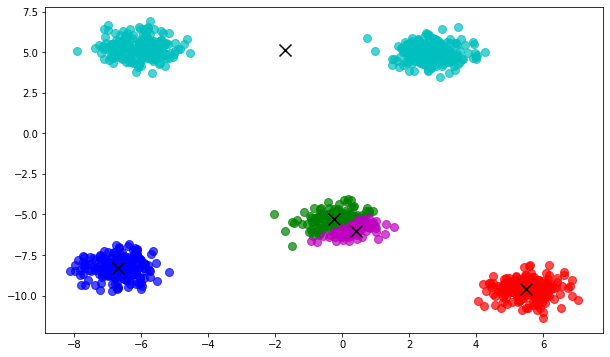

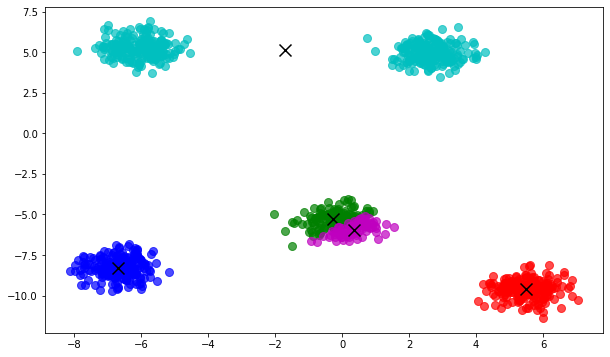

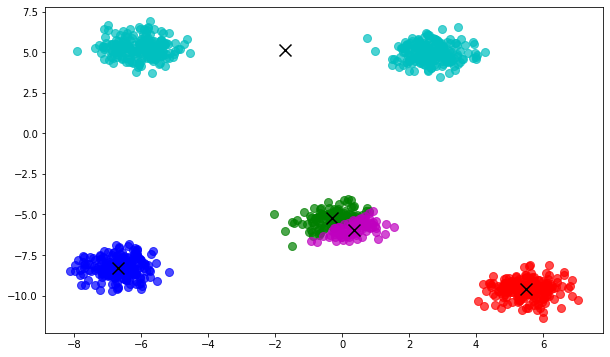

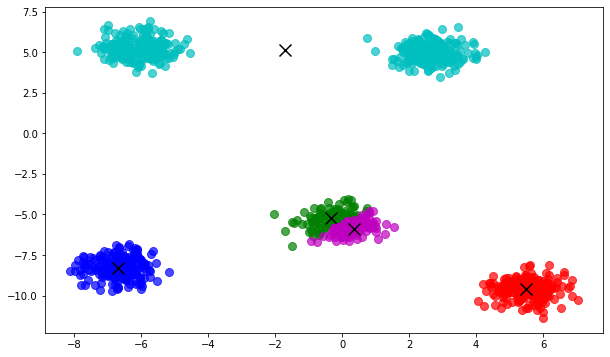

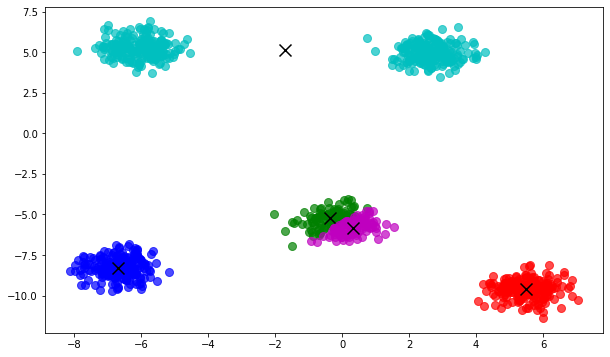

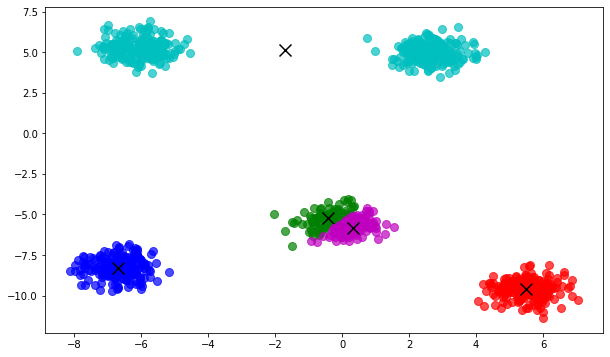

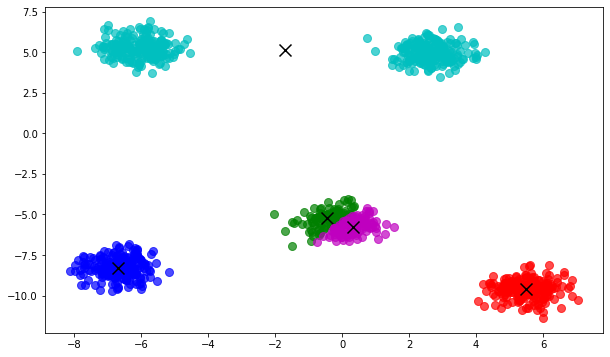

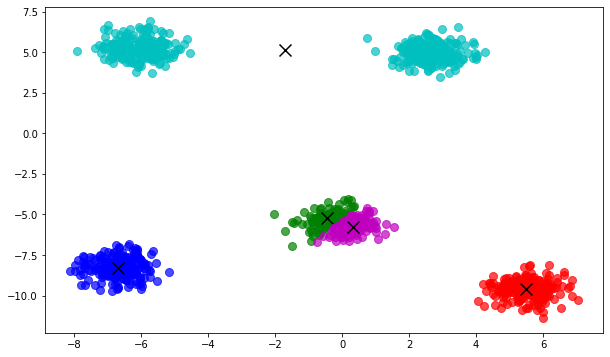

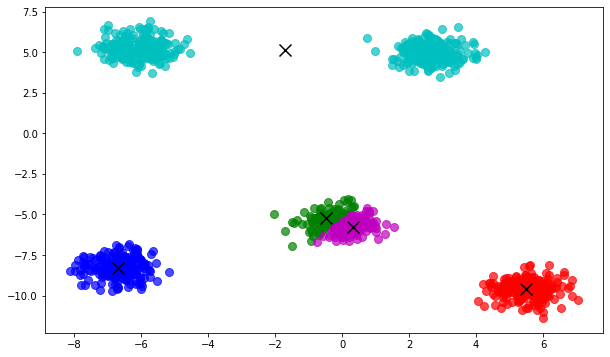

In [5]:
values1=Km1.fit(5)

In [6]:
Km2=KMean(features,plot_steps=True)

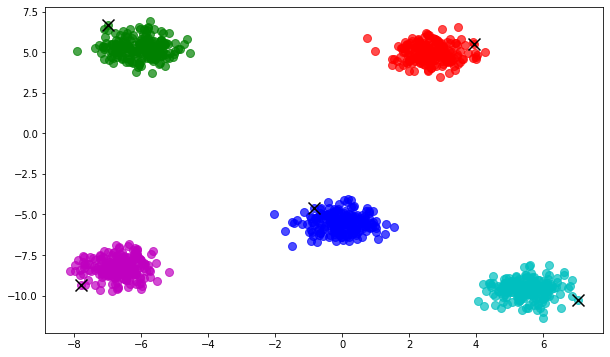

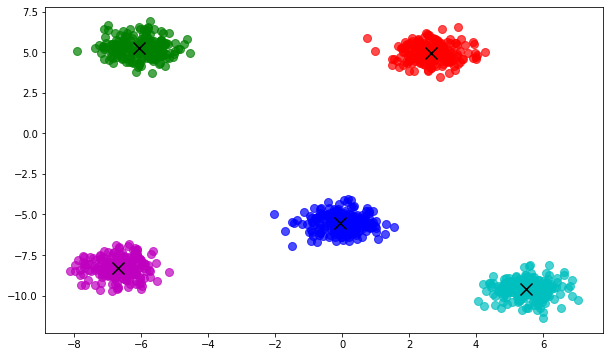

In [7]:
Values2=Km2.fit(5)

In [34]:
Km3 = KMean(features)
# Fac=Km3.silhouette_method(6)

<ipython-input-33-e61ce631741a>:143: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Atemp:
<ipython-input-33-e61ce631741a>:145: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Btemp:


In [10]:
Silhouette_values1=Km3.silhouette_method(7)
Km3.Print_silhoutte_method()
Km3.Show_silhoutte_method()

In [11]:
# Km3.Silh_k_values
Km3.Silhoue_mean

array([       nan,        nan, 0.60361574, 0.65303348, 0.75430398,
       0.86293928, 0.75456178, 0.64049061, 0.52905459, 0.42029648,
       0.31322483])

k=1:65250.6871957869
k=2:24908.134768466385
k=3:13030.531842396324
k=4:5831.7188469759885
k=5:669.4928101529986
k=6:627.512762141783
k=7:576.1830116287447
k=8:529.647378440143
k=9:486.1602391797609
k=10:440.3949439862806


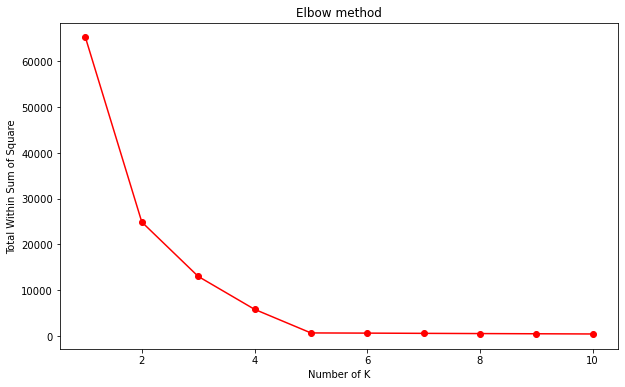

In [24]:
Km3.elbow_method(10)
Km3.Print_elbow_method()
Km3.Show_elbow_method()

In [36]:
Km3.Print_silhoutte_method()

k=2:0.6036157364018033
k=3:0.6530334786547721
k=4:0.7543039824604906
k=5:0.8629392768705967
k=6:0.7545617804247856
k=7:0.6362134294159024


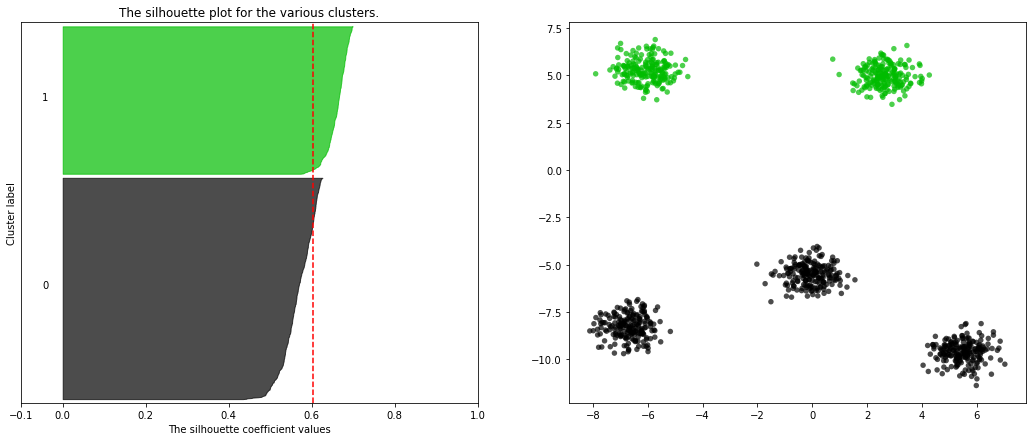

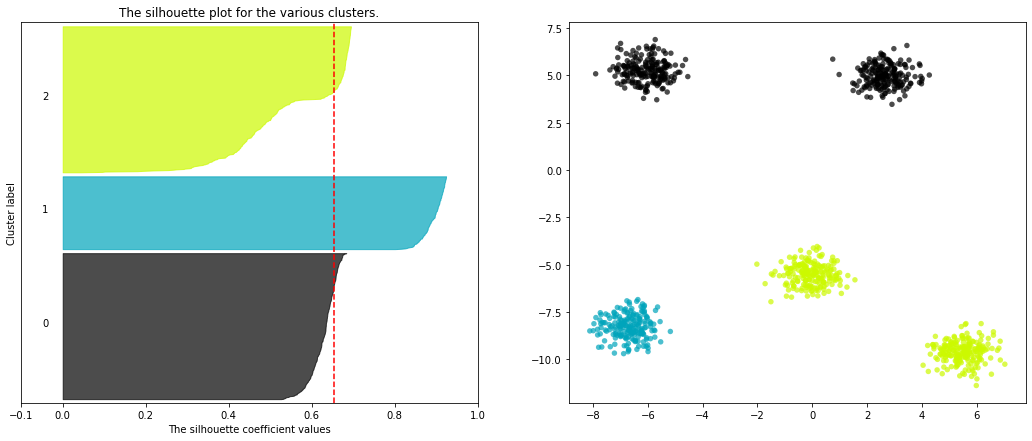

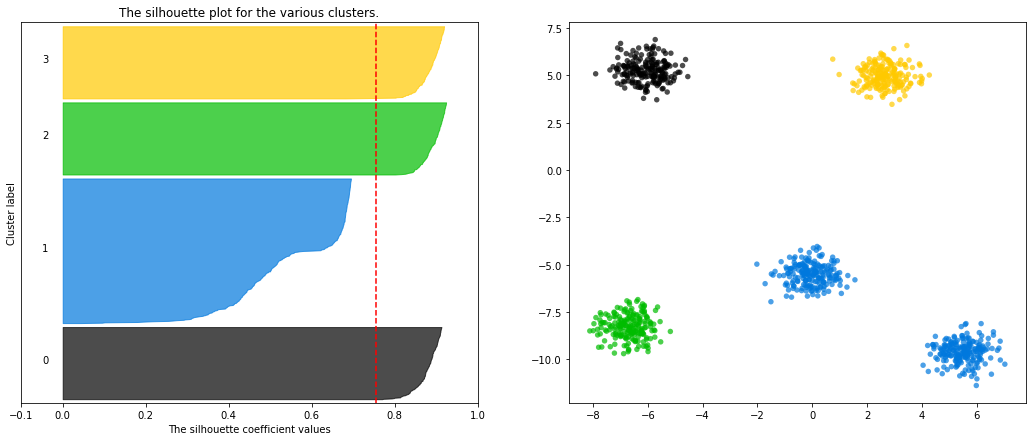

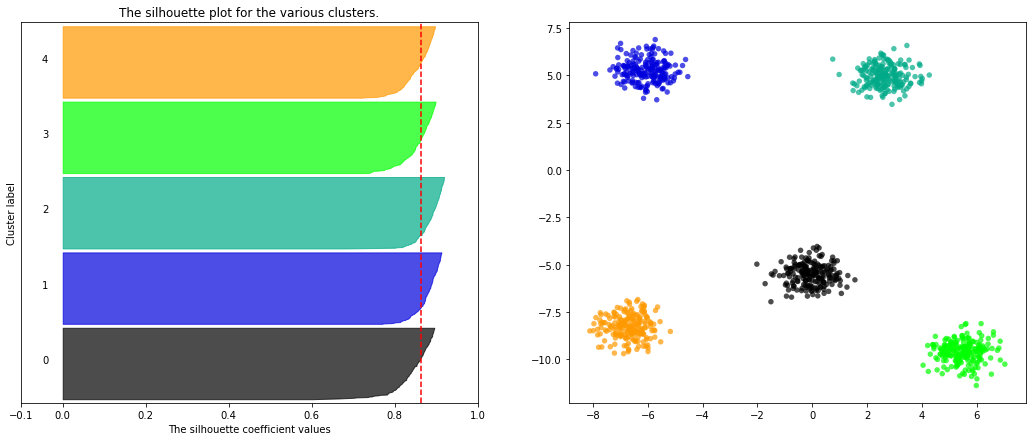

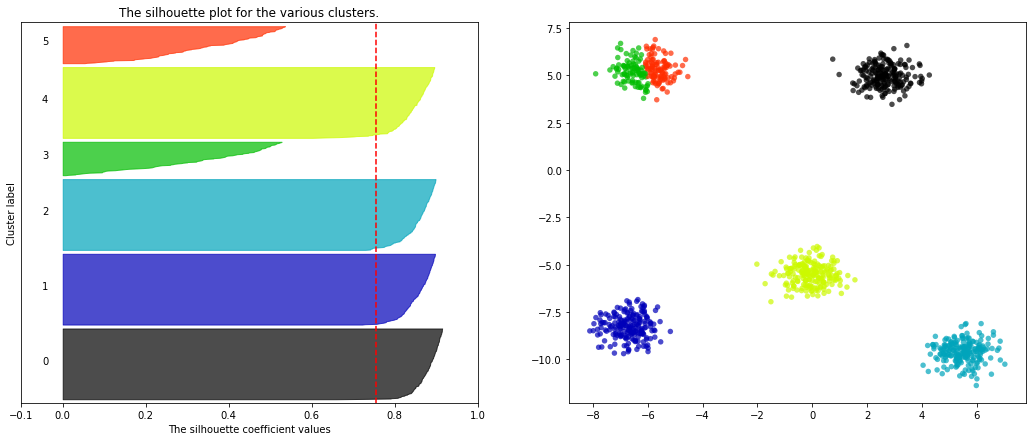

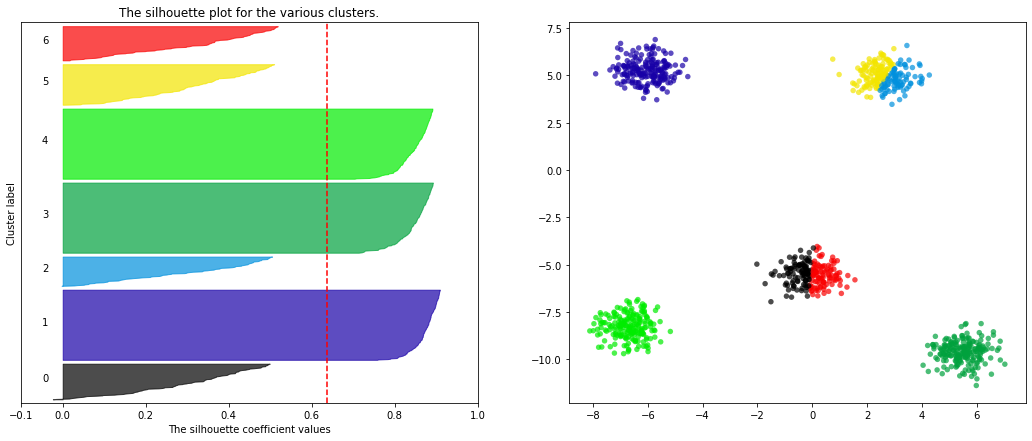

In [37]:
Km3.Show_silhoutte_method()

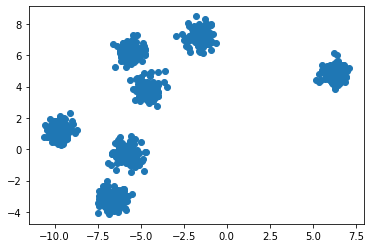

In [14]:
features_1, true_labels_1 = make_blobs(n_samples=1000,centers=7,cluster_std=0.4,random_state=22)
plt.scatter(features_1[:,0],features_1[:,1])

In [15]:
Km4 = KMean(features_1)

In [16]:
Km4.elbow_method(10)

array([           nan, 34891.52834159, 16309.83838208,  5191.99654207,
        3135.49129625,  1470.8265118 ,   829.68356277,   320.09494311,
         307.08412437,   294.62879284,   271.86810539])

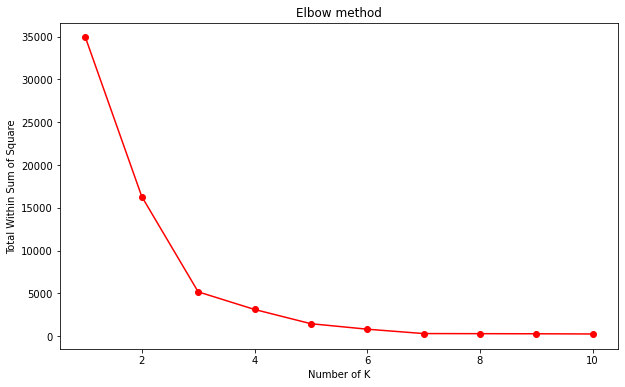

In [17]:
Km4.Show_elbow_method()

In [18]:
Km4.silhouette_method(10)

<ipython-input-2-8daa38eb37b2>:143: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Atemp:
<ipython-input-2-8daa38eb37b2>:145: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Btemp:


[array([[0.59118885, 0.        ],
        [0.62011735, 0.        ],
        [0.57925033, 0.        ],
        ...,
        [0.61831772, 0.        ],
        [0.60868824, 0.        ],
        [0.58741139, 0.        ]]),
 array([[0.65989261, 2.        ],
        [0.5592835 , 2.        ],
        [0.68621823, 2.        ],
        ...,
        [0.60819308, 2.        ],
        [0.62406806, 2.        ],
        [0.62003318, 2.        ]]),
 array([[0.60480095, 2.        ],
        [0.55221624, 2.        ],
        [0.64476819, 2.        ],
        ...,
        [0.58109081, 2.        ],
        [0.55736214, 2.        ],
        [0.5454383 , 2.        ]]),
 array([[0.64321658, 4.        ],
        [0.66662104, 4.        ],
        [0.61980664, 4.        ],
        ...,
        [0.67878429, 4.        ],
        [0.66284428, 4.        ],
        [0.6025168 , 4.        ]]),
 array([[0.64321658, 0.        ],
        [0.64868738, 0.        ],
        [0.61980664, 0.        ],
        ...,
        [

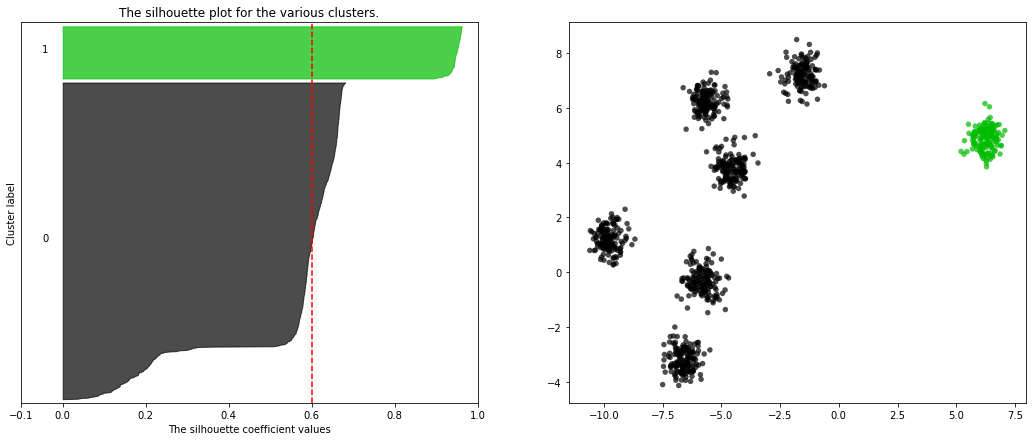

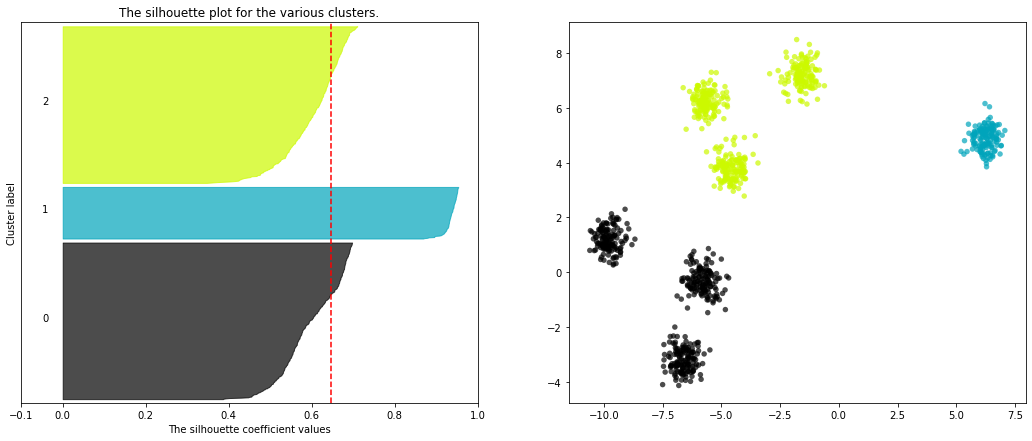

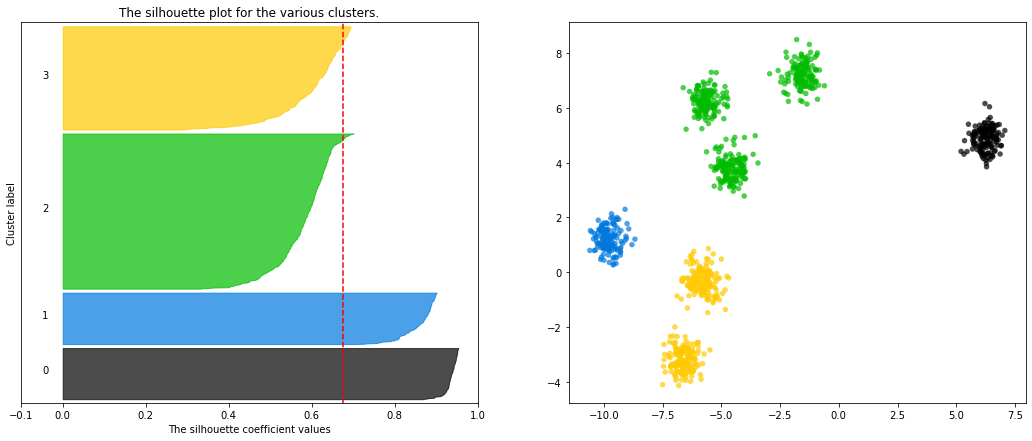

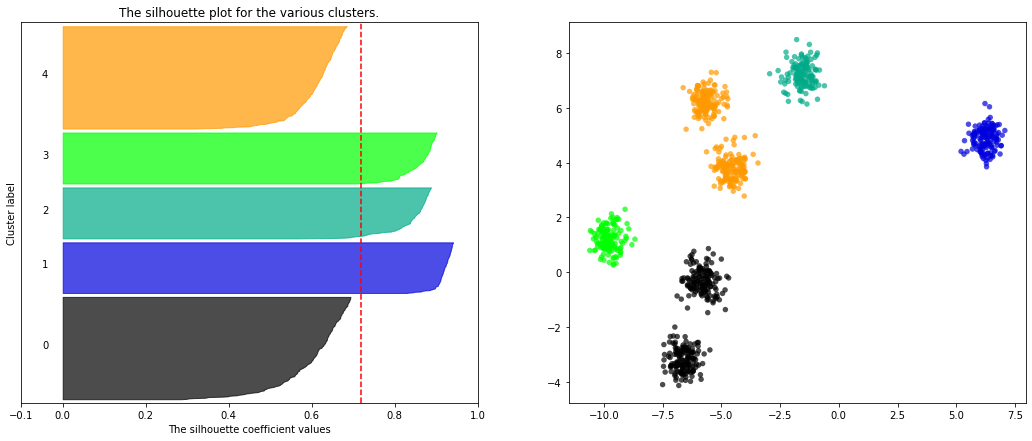

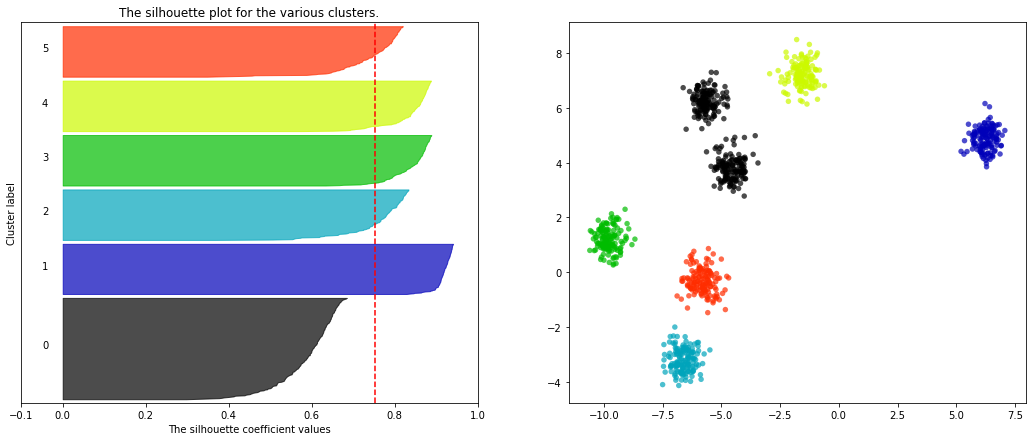

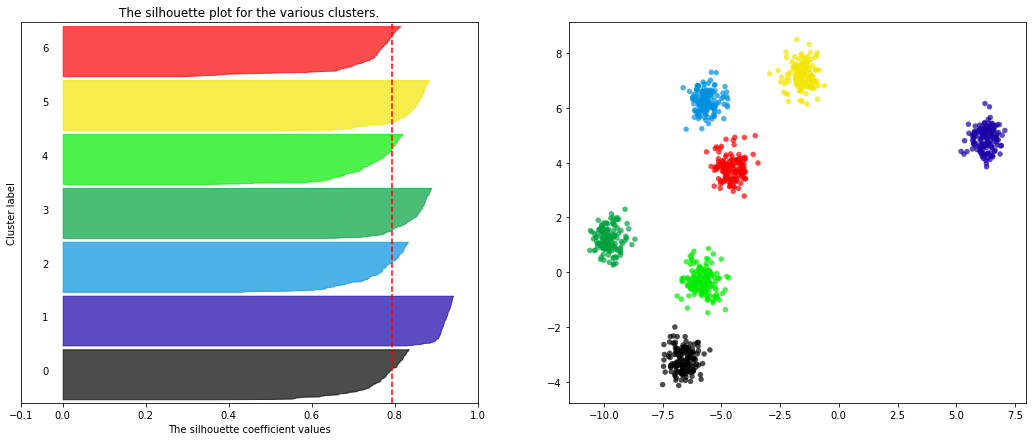

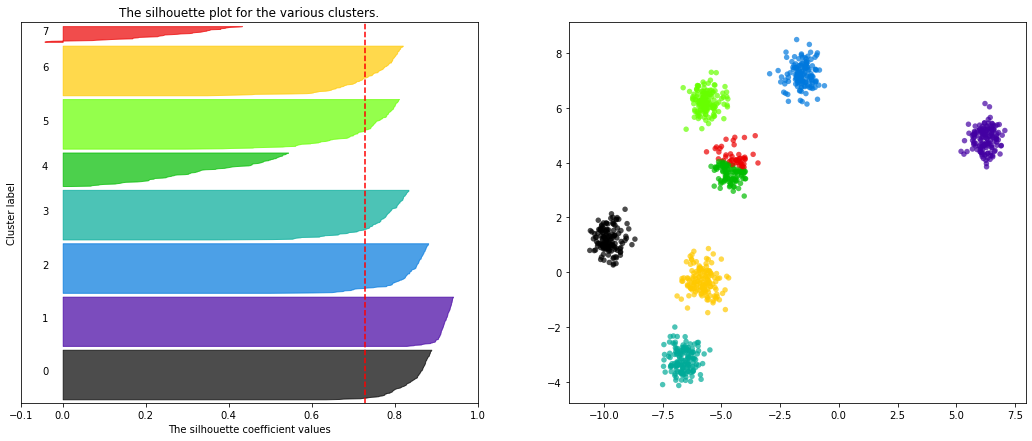

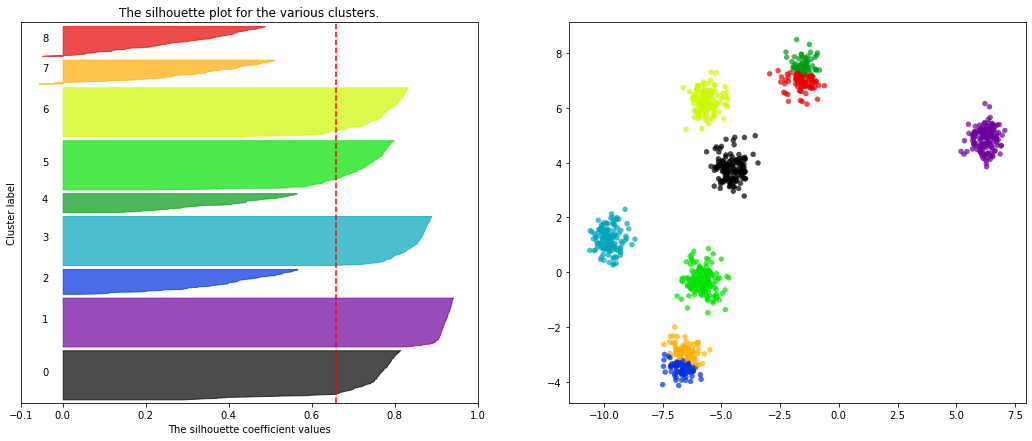

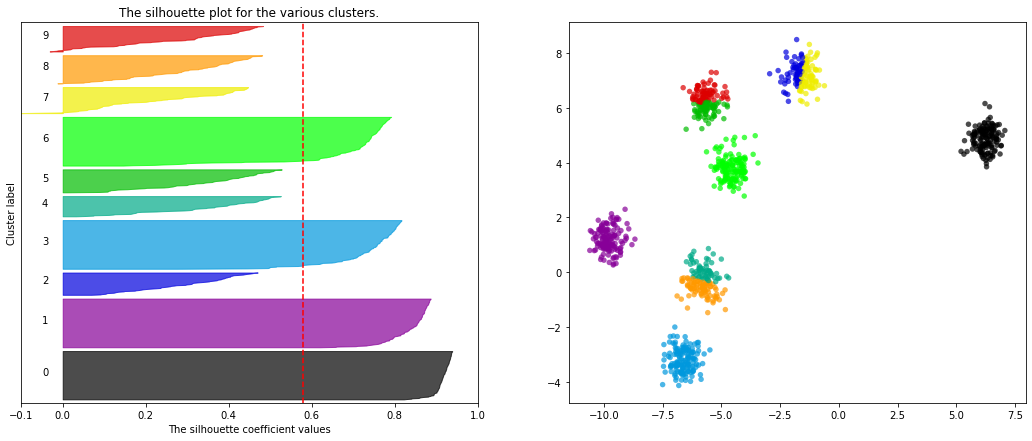

In [19]:
Km4.Show_silhoutte_method()

In [20]:
Km4.fit(7)

(array([[-5.80757182, -0.3231042 ],
        [ 6.24167059,  4.863414  ],
        [-1.56135746,  7.21195595],
        [-5.65197207,  6.23162653],
        [-9.79772113,  1.19241457],
        [-6.62326163, -3.20436857],
        [-4.5741822 ,  3.78919279]]),
 array([3, 6, 3, 3, 4, 0, 4, 4, 2, 4, 6, 3, 5, 3, 2, 1, 5, 2, 0, 3, 1, 1,
        2, 0, 3, 0, 3, 0, 6, 0, 6, 2, 2, 0, 3, 0, 4, 5, 1, 6, 2, 3, 3, 0,
        2, 3, 5, 5, 4, 2, 1, 6, 0, 5, 2, 2, 0, 1, 4, 6, 2, 6, 2, 0, 6, 3,
        3, 5, 1, 4, 6, 5, 2, 2, 3, 3, 3, 2, 6, 3, 1, 3, 2, 6, 2, 4, 4, 2,
        2, 5, 5, 6, 2, 4, 0, 1, 0, 1, 0, 5, 6, 5, 2, 6, 2, 4, 5, 6, 2, 2,
        6, 5, 1, 4, 5, 1, 3, 5, 0, 2, 6, 5, 4, 3, 4, 4, 4, 6, 2, 2, 3, 6,
        5, 3, 6, 2, 1, 5, 2, 4, 0, 0, 6, 0, 0, 0, 6, 1, 3, 2, 2, 1, 0, 2,
        4, 5, 0, 6, 4, 3, 2, 0, 4, 5, 3, 6, 4, 1, 5, 4, 1, 1, 0, 1, 2, 4,
        1, 4, 0, 4, 6, 1, 4, 0, 1, 6, 3, 0, 2, 2, 1, 4, 0, 0, 4, 0, 5, 6,
        6, 6, 0, 5, 6, 3, 6, 1, 4, 4, 1, 0, 4, 3, 0, 0, 1, 1, 4, 3, 3, 4,
      

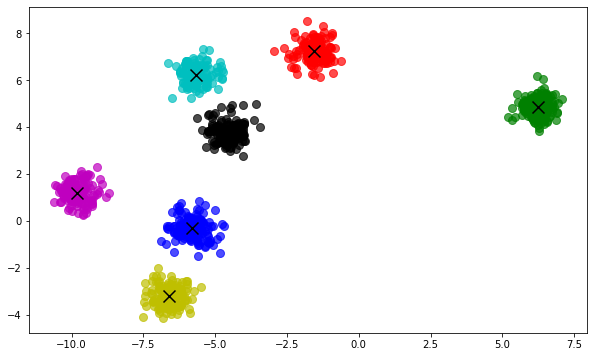

In [21]:
Km4.kmean_plot()

In [22]:
Km4.fit(5)

(array([[-5.11307713,  5.01040966],
        [ 6.24167059,  4.863414  ],
        [-6.21541672, -1.76373638],
        [-9.79772113,  1.19241457],
        [-1.56135746,  7.21195595]]),
 array([0, 0, 0, 0, 3, 2, 3, 3, 4, 3, 0, 0, 2, 0, 4, 1, 2, 4, 2, 0, 1, 1,
        4, 2, 0, 2, 0, 2, 0, 2, 0, 4, 4, 2, 0, 2, 3, 2, 1, 0, 4, 0, 0, 2,
        4, 0, 2, 2, 3, 4, 1, 0, 2, 2, 4, 4, 2, 1, 3, 0, 4, 0, 4, 2, 0, 0,
        0, 2, 1, 3, 0, 2, 4, 4, 0, 0, 0, 4, 0, 0, 1, 0, 4, 0, 4, 3, 3, 4,
        4, 2, 2, 0, 4, 3, 2, 1, 2, 1, 2, 2, 0, 2, 4, 0, 4, 3, 2, 0, 4, 4,
        0, 2, 1, 3, 2, 1, 0, 2, 2, 4, 0, 2, 3, 0, 3, 3, 3, 0, 4, 4, 0, 0,
        2, 0, 0, 4, 1, 2, 4, 3, 2, 2, 0, 2, 2, 2, 0, 1, 0, 4, 4, 1, 2, 4,
        3, 2, 2, 0, 3, 0, 4, 2, 3, 2, 0, 0, 3, 1, 2, 3, 1, 1, 2, 1, 4, 3,
        1, 3, 2, 3, 0, 1, 3, 2, 1, 0, 0, 2, 4, 4, 1, 3, 2, 2, 3, 2, 2, 0,
        0, 0, 2, 2, 0, 0, 0, 1, 3, 3, 1, 2, 3, 0, 2, 2, 1, 1, 3, 0, 0, 3,
        0, 1, 2, 1, 3, 3, 0, 3, 2, 1, 2, 4, 2, 2, 1, 3, 2, 2, 0, 1, 2, 0,
    